# Import Data

This file is being used to display our group's approach for feature subset selection and hyperparameter tuning for the Random Forest model we developed (that is presented in the main file). Because the two processes could take up to 19 hours, we have opted to submit this second file to showcase our approach regarding our selection of features and hyperparameters while keeping the runtime of the main file to a minimum.

Import necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
from collections import Counter
from google.colab import drive # using to connect to kaggle for our dataset

Download the dataset (note that you will have to upload a kaggle.json file to be able to use this)

In [2]:
# download dataset:
from google.colab import drive
drive.mount('/content/drive')
!mkdir ~/.kaggle
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# Download dataset
!!kaggle datasets download -d adarshsng/lending-club-loan-data-csv
# Unzip folder in Colab content folder
!unzip /content/lending-club-loan-data-csv.zip

Mounted at /content/drive
Archive:  /content/lending-club-loan-data-csv.zip
  inflating: LCDataDictionary.xlsx   
  inflating: loan.csv                


Read in data in chunks.

In [3]:
import time
start = time.time()
#read data in chunks
chunk = pd.read_csv('loan.csv',chunksize=250000, low_memory=False)
end = time.time()
print("Read csv with chunks: ",(end-start),"sec")
df = pd.concat(chunk)

Read csv with chunks:  0.004222869873046875 sec


In [4]:
# delete unnecessary variables to save on RAM
del start, end, chunk

The data should have >2MM rows which is too large for Colab's RAM limitations. Ultimately, we will sample a data-set from this global sample to work within Colab's limitations given the TA's guidance to avoid using Colab Pro.

In [5]:
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260663,NaN,NaN,12000,12000,12000.0,60 months,14.08,279.72,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260664,NaN,NaN,12000,12000,12000.0,60 months,25.82,358.01,E,E4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260665,NaN,NaN,10000,10000,10000.0,36 months,11.99,332.10,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260666,NaN,NaN,12000,12000,12000.0,60 months,21.45,327.69,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning and Data Wrangling

## Handling null values


First, let us handle the null values in our data-set. In this next cell, we will eliminate those columns within which > 30% of the column has null values.

In [6]:
rows = len(df['id'])

drop_columns = []

for col in list(df.columns):
  if df[col].isnull().sum() >= rows*.3:
    drop_columns.append(col)
    print("We are dropping the column titled: " + col)
df = df.drop(columns=drop_columns)

We are dropping the column titled: id
We are dropping the column titled: member_id
We are dropping the column titled: url
We are dropping the column titled: desc
We are dropping the column titled: mths_since_last_delinq
We are dropping the column titled: mths_since_last_record
We are dropping the column titled: next_pymnt_d
We are dropping the column titled: mths_since_last_major_derog
We are dropping the column titled: annual_inc_joint
We are dropping the column titled: dti_joint
We are dropping the column titled: verification_status_joint
We are dropping the column titled: open_acc_6m
We are dropping the column titled: open_act_il
We are dropping the column titled: open_il_12m
We are dropping the column titled: open_il_24m
We are dropping the column titled: mths_since_rcnt_il
We are dropping the column titled: total_bal_il
We are dropping the column titled: il_util
We are dropping the column titled: open_rv_12m
We are dropping the column titled: open_rv_24m
We are dropping the column

In [7]:
# delete unnecessary variables to save on RAM
del drop_columns

Let us make sure that df was updated as expected.

In [8]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,...,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,...,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,...,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,...,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,...,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260663,12000,12000,12000.0,60 months,14.08,279.72,C,C3,house keeper,10+ years,...,66.7,0.0,0.0,73948.0,45212.0,6200.0,49448.0,N,Cash,N
2260664,12000,12000,12000.0,60 months,25.82,358.01,E,E4,Skilled Labor,< 1 year,...,50.0,0.0,0.0,382275.0,12928.0,11400.0,12125.0,N,Cash,N
2260665,10000,10000,10000.0,36 months,11.99,332.10,B,B5,Teacher,10+ years,...,100.0,0.0,0.0,203417.0,36448.0,2000.0,29317.0,N,Cash,N
2260666,12000,12000,12000.0,60 months,21.45,327.69,D,D5,NaN,NaN,...,0.0,0.0,0.0,118975.0,65238.0,22000.0,81975.0,N,Cash,N


Now let us check the proportion of null values in each column.

In [9]:
for col in list(df.columns):
  if df[col].isnull().sum()/rows > 0:
    print(str(col)+": "+ str(round(df[col].isnull().sum()/rows,4)))

emp_title: 0.0739
emp_length: 0.065
annual_inc: 0.0
title: 0.0103
zip_code: 0.0
dti: 0.0008
delinq_2yrs: 0.0
earliest_cr_line: 0.0
inq_last_6mths: 0.0
open_acc: 0.0
pub_rec: 0.0
revol_util: 0.0008
total_acc: 0.0
last_pymnt_d: 0.0011
last_credit_pull_d: 0.0
collections_12_mths_ex_med: 0.0001
acc_now_delinq: 0.0
tot_coll_amt: 0.0311
tot_cur_bal: 0.0311
total_rev_hi_lim: 0.0311
acc_open_past_24mths: 0.0221
avg_cur_bal: 0.0311
bc_open_to_buy: 0.0331
bc_util: 0.0336
chargeoff_within_12_mths: 0.0001
delinq_amnt: 0.0
mo_sin_old_il_acct: 0.0615
mo_sin_old_rev_tl_op: 0.0311
mo_sin_rcnt_rev_tl_op: 0.0311
mo_sin_rcnt_tl: 0.0311
mort_acc: 0.0221
mths_since_recent_bc: 0.0325
mths_since_recent_inq: 0.1307
num_accts_ever_120_pd: 0.0311
num_actv_bc_tl: 0.0311
num_actv_rev_tl: 0.0311
num_bc_sats: 0.0259
num_bc_tl: 0.0311
num_il_tl: 0.0311
num_op_rev_tl: 0.0311
num_rev_accts: 0.0311
num_rev_tl_bal_gt_0: 0.0311
num_sats: 0.0259
num_tl_120dpd_2m: 0.068
num_tl_30dpd: 0.0311
num_tl_90g_dpd_24m: 0.0311
num_t

Each column has a limited proportion of null values; hence, we think it is fine to just drop these rows given the size of the dataset.

In [10]:
df = df.dropna()

In [11]:
# check df again
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,...,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,...,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,...,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,...,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,...,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260658,15000,15000,15000.0,60 months,16.02,364.94,C,C5,Instructional Designer,< 1 year,...,0.0,0.0,0.0,267274.0,239081.0,22900.0,239074.0,N,Cash,N
2260662,30000,30000,30000.0,60 months,30.75,984.47,F,F5,Sales,6 years,...,50.0,0.0,0.0,201286.0,68680.0,16500.0,64086.0,N,Cash,N
2260663,12000,12000,12000.0,60 months,14.08,279.72,C,C3,house keeper,10+ years,...,66.7,0.0,0.0,73948.0,45212.0,6200.0,49448.0,N,Cash,N
2260664,12000,12000,12000.0,60 months,25.82,358.01,E,E4,Skilled Labor,< 1 year,...,50.0,0.0,0.0,382275.0,12928.0,11400.0,12125.0,N,Cash,N


In [12]:
del rows

Our dataset is too large to work with; hence, we will use a sub-set.

In [13]:
seed = 42
df = df.sample(n = 300000, random_state=seed)

In [14]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
261309,9000,9000,9000.0,36 months,6.83,277.20,A,A3,Test Engineer,5 years,...,0.0,0.0,0.0,295439.0,18346.0,14100.0,22603.0,N,Cash,N
310885,30000,30000,30000.0,60 months,18.45,769.17,D,D2,Production manager / programmer,10+ years,...,100.0,0.0,0.0,160943.0,30689.0,23800.0,5044.0,N,Cash,N
1909821,15000,15000,15000.0,36 months,7.69,467.91,A,A4,Department Manager,10+ years,...,50.0,0.0,0.0,293143.0,58613.0,9500.0,48543.0,N,Cash,N
180491,30000,30000,30000.0,60 months,13.56,691.23,C,C1,Officer,10+ years,...,0.0,0.0,0.0,412315.0,33744.0,36500.0,27865.0,N,Cash,N
1345526,5600,5600,5600.0,36 months,14.99,194.10,C,C5,Driver/Warehouse,6 years,...,0.0,0.0,0.0,86687.0,101623.0,4700.0,78787.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871946,40000,40000,40000.0,36 months,13.99,1366.92,C,C3,Director of Curriculum,10+ years,...,60.0,0.0,0.0,125100.0,95646.0,125100.0,0.0,N,Cash,N
1316255,2000,2000,2000.0,36 months,12.39,66.81,C,C1,Educator,10+ years,...,100.0,0.0,0.0,420493.0,114386.0,38200.0,75793.0,N,Cash,N
1152639,16000,16000,16000.0,60 months,13.33,366.76,C,C3,Supervisor,10+ years,...,50.0,0.0,0.0,39961.0,13040.0,3100.0,34961.0,N,Cash,N
340490,14000,14000,14000.0,36 months,17.47,502.42,D,D1,Property Manager,4 years,...,100.0,0.0,0.0,50529.0,31383.0,13000.0,26129.0,N,Cash,N


## Data cleaning

This section includes general data cleaning as well as casting data types to the appropriate data types

In [15]:
#We will replace strings within emp_length to ensure that this feature only contains numeric information
df['emp_length'] = df['emp_length'].apply(lambda x: str(x).replace(" years", "").replace(" year", "").replace("< ","").replace("+",""))

#We will also reset the index
df = df.reset_index(drop=True)

In [16]:
#We ensure that term only contains numeric information
df['term'] = df['term'].apply(lambda x: x.replace(" months", "")).astype('int64')

There are four variables ('issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d') that refer to the date when the loan was issued, the earliest credit line that the borrower borrowed, the last payment date made by the borrower, and the last credit report pulled on the borrower, respectively. We are going to use these variables to prepare another variable that is specific to each borrower which represents the borrower's seasoning. This will be 'earliest_cr_line' minus 'last_pymnt_d'. We will use this special variable and drop the other variables. Ultimately, we are trying to bring our dataset to a strict dataset of numbers that can be put into machine learning models.

In [17]:
df = df.drop(columns=['issue_d', 'last_credit_pull_d'])

In [18]:
# write function to convert date time string in the following columns
from datetime import datetime
def convert_to_date(datestring):
  dt = datetime.strptime(datestring, '%b-%Y')
  return dt

In [19]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: convert_to_date(x))
df['last_pymnt_d'] = df['last_pymnt_d'].apply(lambda x: convert_to_date(x))

In [20]:
df['seasoning'] = (df['last_pymnt_d'] - df['earliest_cr_line'])
df = df.drop(columns=['last_pymnt_d', 'earliest_cr_line'])

In [21]:
df['seasoning'] = df['seasoning'].apply(lambda x: x.days)

In [22]:
pd.set_option('display.max_columns', None)
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,seasoning
0,9000,9000,9000.0,36,6.83,277.20,A,A3,Test Engineer,5,MORTGAGE,137000.0,Not Verified,Current,n,debt_consolidation,Debt consolidation,181xx,PA,6.60,1.0,0.0,6.0,0.0,8757,62.1,11.0,w,7390.90,7390.90,1954.820000,1954.82,1609.10,345.72,0.0,0.0,0.0,277.20,0.0,1,Individual,0.0,0.0,206519.0,14100.0,1.0,34420.0,5343.0,62.1,0.0,0.0,130.0,72.0,7.0,7.0,3.0,7.0,7.0,1.0,3.0,3.0,3.0,3.0,5.0,3.0,3.0,3.0,6.0,0.0,0.0,1.0,1.0,81.8,0.0,0.0,0.0,295439.0,18346.0,14100.0,22603.0,N,Cash,N,5266
1,30000,30000,30000.0,60,18.45,769.17,D,D2,Production manager / programmer,10,MORTGAGE,120000.0,Source Verified,Current,n,credit_card,Credit card refinancing,480xx,MI,10.52,0.0,0.0,9.0,0.0,28773,97.2,15.0,w,27052.03,27052.03,7014.780000,7014.78,2947.97,4066.81,0.0,0.0,0.0,769.17,0.0,1,Individual,0.0,365.0,121858.0,29600.0,2.0,13540.0,0.0,100.3,0.0,0.0,113.0,173.0,17.0,17.0,4.0,44.0,17.0,0.0,4.0,5.0,4.0,6.0,3.0,6.0,8.0,5.0,9.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,160943.0,30689.0,23800.0,5044.0,N,Cash,N,10199
2,15000,15000,15000.0,36,7.69,467.91,A,A4,Department Manager,10,MORTGAGE,101000.0,Verified,Fully Paid,n,other,Other,028xx,RI,13.96,1.0,0.0,9.0,0.0,37198,83.4,24.0,w,0.00,0.00,16849.939071,16849.94,15000.00,1849.94,0.0,0.0,0.0,467.65,0.0,1,Individual,0.0,0.0,167871.0,44600.0,3.0,18652.0,2304.0,75.7,0.0,0.0,170.0,493.0,14.0,14.0,1.0,14.0,16.0,0.0,4.0,5.0,4.0,12.0,5.0,6.0,18.0,5.0,9.0,0.0,0.0,0.0,0.0,83.3,50.0,0.0,0.0,293143.0,58613.0,9500.0,48543.0,N,Cash,N,16132
3,30000,30000,30000.0,60,13.56,691.23,C,C1,Officer,10,MORTGAGE,130000.0,Verified,Current,n,home_improvement,Home improvement,956xx,CA,7.18,0.0,0.0,6.0,0.0,11154,31.9,8.0,w,27826.01,27826.01,4124.780000,4124.78,2173.99,1950.79,0.0,0.0,0.0,691.23,0.0,1,Joint App,0.0,0.0,356428.0,41500.0,2.0,59405.0,25346.0,37.2,0.0,0.0,124.0,124.0,28.0,17.0,2.0,28.0,0.0,0.0,1.0,1.0,2.0,2.0,3.0,3.0,3.0,1.0,6.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,412315.0,33744.0,36500.0,27865.0,N,Cash,N,3958
4,5600,5600,5600.0,36,14.99,194.10,C,C5,Driver/Warehouse,6,RENT,29000.0,Source Verified,Fully Paid,n,debt_consolidation,Debt consolidation,674xx,KS,21.81,0.0,5.0,10.0,0.0,2720,34.4,19.0,f,0.00,0.00,6574.240000,6574.24,5600.00,974.24,0.0,0.0,0.0,3477.97,0.0,1,Individual,0.0,0.0,101623.0,7900.0,4.0,11291.0,2370.0,49.6,0.0,0.0,195.0,117.0,1.0,1.0,0.0,1.0,0.0,0.0,4.0,5.0,4.0,4.0,12.0,7.0,7.0,5.0,10.0,0.0,0.0,0.0,2.0,76.5,0.0,0.0,0.0,86687.0,101623.0,4700.0,78787.0,N,Cash,N,6483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,40000,40000,40000.0,36,13.99,1366.92,C,

In [23]:
# convert string data to string, just to ensure consistency in data types
for val in ['debt_settlement_flag', 'disbursement_method', 'hardship_flag', 'application_type', 'initial_list_status', 'addr_state',  'zip_code', 'title', 'purpose', 'pymnt_plan', 'loan_status', 'verification_status', 'home_ownership', 'emp_title', 'grade', 'sub_grade']:
  df[val] = df[val].astype(str)
  df[val] = df[val].apply(lambda x: str(x).strip().lower())

In [24]:
# similarly, convert all int data to int to ensure consistency
for val in ['loan_amnt','funded_amnt','funded_amnt_inv','term','recoveries','annual_inc','collections_12_mths_ex_med','inq_last_6mths','delinq_2yrs','open_acc','total_acc','pub_rec','acc_now_delinq','tax_liens','bc_open_to_buy','acc_open_past_24mths','chargeoff_within_12_mths','mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op','mort_acc','mo_sin_old_il_acct','mo_sin_rcnt_tl','mths_since_recent_bc','mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','pub_rec_bankruptcies','num_tl_op_past_12m','num_tl_90g_dpd_24m','num_tl_30dpd','num_tl_120dpd_2m','num_sats','num_rev_tl_bal_gt_0','num_rev_accts','num_il_tl','num_op_rev_tl']:
  df[val] = df[val].astype(int)

In [25]:
# similarly, convert all float data to float to ensure consistency
for val in ['total_il_high_credit_limit','total_bc_limit','total_bal_ex_mort','tot_hi_cred_lim','percent_bc_gt_75','installment','int_rate','pct_tl_nvr_dlq','dti','delinq_amnt','bc_util','avg_cur_bal','total_rev_hi_lim','revol_bal','revol_util','tot_cur_bal','tot_coll_amt','last_pymnt_amnt','collection_recovery_fee','out_prncp','out_prncp_inv',	'total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee']:
  df[val] = df[val].astype(float)

Upon further inspection of the data, it would appear that the *zip_code* field contains only partial zipcode data. This is likely a result of privacy related issues. We will make the decision to drop the feature because it is technically incomplete data which only provides us with the first three digits of a zipcode.

In [26]:
df = df.drop(columns=['zip_code'])

## One Hot Encoding

Now we will one hot encode our data and finish preparing it for the EDA phase of our engagement.

One hot encoding can be RAM intensive; hence, we go through all of our categorical variables and only preserve the most important ones based on intuition.

In [27]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,seasoning
0,9000,9000,9000,36,6.83,277.20,a,a3,test engineer,5,mortgage,137000,not verified,current,n,debt_consolidation,debt consolidation,pa,6.60,1,0,6,0,8757.0,62.1,11,w,7390.90,7390.90,1954.820000,1954.82,1609.10,345.72,0.0,0,0.0,277.20,0,1,individual,0,0.0,206519.0,14100.0,1,34420.0,5343,62.1,0,0.0,130,72,7,7,3,7,7,1,3,3,3,3,5,3,3,3,6,0,0,1,1,81.8,0.0,0,0,295439.0,18346.0,14100.0,22603.0,n,cash,n,5266
1,30000,30000,30000,60,18.45,769.17,d,d2,production manager / programmer,10,mortgage,120000,source verified,current,n,credit_card,credit card refinancing,mi,10.52,0,0,9,0,28773.0,97.2,15,w,27052.03,27052.03,7014.780000,7014.78,2947.97,4066.81,0.0,0,0.0,769.17,0,1,individual,0,365.0,121858.0,29600.0,2,13540.0,0,100.3,0,0.0,113,173,17,17,4,44,17,0,4,5,4,6,3,6,8,5,9,0,0,0,0,100.0,100.0,0,0,160943.0,30689.0,23800.0,5044.0,n,cash,n,10199
2,15000,15000,15000,36,7.69,467.91,a,a4,department manager,10,mortgage,101000,verified,fully paid,n,other,other,ri,13.96,1,0,9,0,37198.0,83.4,24,w,0.00,0.00,16849.939071,16849.94,15000.00,1849.94,0.0,0,0.0,467.65,0,1,individual,0,0.0,167871.0,44600.0,3,18652.0,2304,75.7,0,0.0,170,493,14,14,1,14,16,0,4,5,4,12,5,6,18,5,9,0,0,0,0,83.3,50.0,0,0,293143.0,58613.0,9500.0,48543.0,n,cash,n,16132
3,30000,30000,30000,60,13.56,691.23,c,c1,officer,10,mortgage,130000,verified,current,n,home_improvement,home improvement,ca,7.18,0,0,6,0,11154.0,31.9,8,w,27826.01,27826.01,4124.780000,4124.78,2173.99,1950.79,0.0,0,0.0,691.23,0,1,joint app,0,0.0,356428.0,41500.0,2,59405.0,25346,37.2,0,0.0,124,124,28,17,2,28,0,0,1,1,2,2,3,3,3,1,6,0,0,0,0,100.0,0.0,0,0,412315.0,33744.0,36500.0,27865.0,n,cash,n,3958
4,5600,5600,5600,36,14.99,194.10,c,c5,driver/warehouse,6,rent,29000,source verified,fully paid,n,debt_consolidation,debt consolidation,ks,21.81,0,5,10,0,2720.0,34.4,19,f,0.00,0.00,6574.240000,6574.24,5600.00,974.24,0.0,0,0.0,3477.97,0,1,individual,0,0.0,101623.0,7900.0,4,11291.0,2370,49.6,0,0.0,195,117,1,1,0,1,0,0,4,5,4,4,12,7,7,5,10,0,0,0,2,76.5,0.0,0,0,86687.0,101623.0,4700.0,78787.0,n,cash,n,6483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,40000,40000,40000,36,13.99,1366.92,c,c3,director of curriculum,10,rent,119000,source verified,fully paid,n,debt_consolidation,debt consolidation,ak,17.37,0,0,6,0,95646.0,59.7,12,w,0.00,0.00,43981.193038,43981.19,40000.00,3981.19,0.0,0,0.0,1364.72,0,1,individual,0,0.0,95646.0,125100.0,0,19129.0,29454,59.7,0,0.0,75,287,43,27,0,43,18,0,4,4,6,9,2,6,10,4,6,0,0,0,0,100.0,60.0,0,0,125100.0,95646.0,125100.0,0.0,n,cash,n,9070
299996,2000



*   Removing 'title' which indicates the title of the loan provided by the borrower; however, we are preserving 'purpose' which already indicates the purpose of the loan
*   Removing 'initial_list_status' which indicates the initial listing status of the loan - listed in the whole or fractional market (doesn't seem intuitively connected to whether a loan is healthy or not).
*   Removing 'policy_code' which indicates whether the policy is publicly available or not (doesn't seem intuitively connected to whether a loan is healthy or not).
*   Removing 'disbursement_method' which indicates how the borrower received the loan (doesn't seem intuitively connected to whether a loan is healthy or not).
*   Removing 'debt_settlement_flag' which indicates whether a charged-off borrower is working with a debt settlement company (this variable is directly related to the dependent variable; hence, we will drop this).
*   Removing 'hardship_flag' which indicates whether a borrower is in hardship or not (already contains information we are trying to predict; hence, we will drop this)
*   Removing 'grade' and 'sub-grade' because they are directly related to whether the loan is healthy or not.

In [28]:
df = df.drop(columns=['grade', 'sub_grade', 'title', 'initial_list_status', 'policy_code', 'disbursement_method', 'debt_settlement_flag', 'hardship_flag'])

Let us visualize the variable of interest.

<Axes: xlabel='loan_status', ylabel='count'>

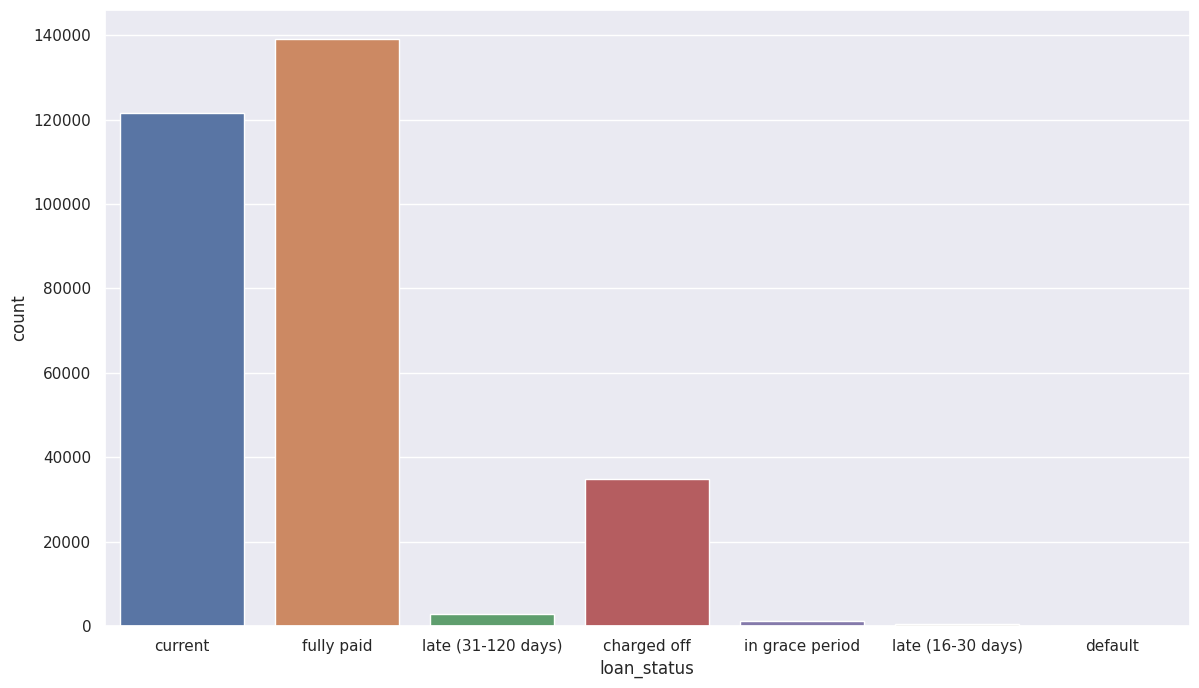

In [29]:
sns.set(rc={'figure.figsize':(14,8)})
sns.countplot(x = df['loan_status'])

We will restructure this variable to have '1' if it is current or fully paid and '0' for all other categories. We will essentially predict if the loan is 'healthy' or not.

In [30]:
def status(x):
  if x == "current" or x == "fully paid":
    return 1
  else:
    return 0

In [31]:
df['loan_status'] = df['loan_status'].apply(lambda x: status(x))

'recoveries' feature in the data-set refers to post charge-off gross recovery.
'collection_recovery_fee' feature in the data-set refers to post charge-off recovery fee. These variables are directly related to the aforementioned dependent variable; hence, we will drop these two features.

In [32]:
df = df.drop(columns=['recoveries', 'collection_recovery_fee'])

In lieu of one-hot encoding >50 states, let us find another way to consider this information.

<Axes: xlabel='addr_state', ylabel='count'>

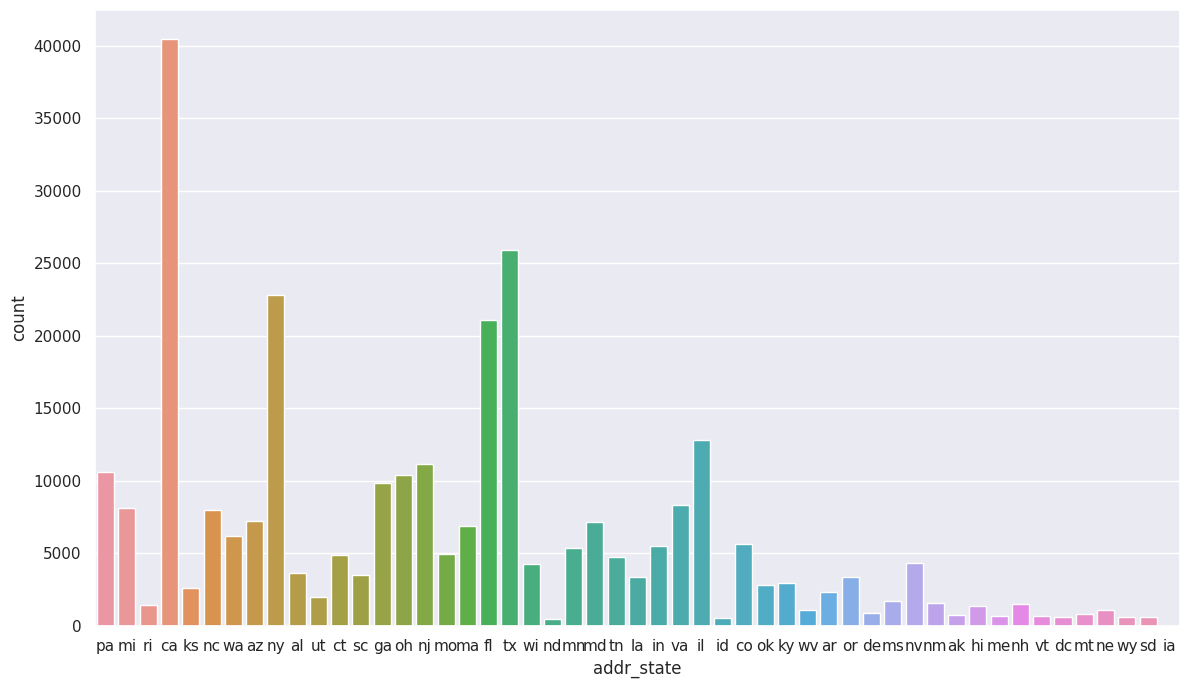

In [33]:
sns.set(rc={'figure.figsize':(14,8)})
sns.countplot(x = df['addr_state'])

Let us look at the relationship between U.S. state and loan_status

In [34]:
statbystate = df[['loan_status', 'addr_state']].groupby(['addr_state'], as_index = False, sort=False).sum()
statbystate = statbystate.sort_values(by=['loan_status'], ascending = False)

In [35]:
statbystate

,addr_state,loan_status
3,ca,35092
19,tx,22397
8,ny,19284
18,fl,18194
28,il,11400
15,nj,9607
0,pa,9184
14,oh,9109
13,ga,8695
27,va,7228


Let us break the U.S. state variable into five dummy variable buckets

In [36]:
statbystate = statbystate.values.tolist()

In [37]:
j = 0
thedic = {}
while j < 10:
  thedic[statbystate[j][0]] = 1
  j += 1
while j < 20:
  thedic[statbystate[j][0]] = 2
  j += 1
while j < 30:
  thedic[statbystate[j][0]] = 3
  j += 1
while j < 40:
  thedic[statbystate[j][0]] = 4
  j += 1
while j < len(statbystate):
  thedic[statbystate[j][0]] = 5
  j += 1

In [38]:
def st(x):
  return thedic[x]

In [39]:
df['addr_state'] = df['addr_state'].apply(lambda x: st(x))

In [40]:
# delete unnecessary variables to save on RAM
del statbystate

In [41]:
# Finally, we can do the one hot encoding of relevant categorical variables.
categorical_features = ['verification_status', 'application_type', 'pymnt_plan', 'addr_state', 'purpose', 'home_ownership']
df = pd.get_dummies(df, columns=categorical_features)
# delete unnecessary variables to save on RAM
del categorical_features

In [42]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_title,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,seasoning,verification_status_not verified,verification_status_source verified,verification_status_verified,application_type_individual,application_type_joint app,pymnt_plan_n,pymnt_plan_y,addr_state_1,addr_state_2,addr_state_3,addr_state_4,addr_state_5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_any,home_ownership_mortgage,home_ownership_none,home_ownership_other,home_ownership_own,home_ownership_rent
0,9000,9000,9000,36,6.83,277.20,test engineer,5,137000,1,6.60,1,0,6,0,8757.0,62.1,11,7390.90,7390.90,1954.820000,1954.82,1609.10,345.72,0.0,277.20,0,0,0.0,206519.0,14100.0,1,34420.0,5343,62.1,0,0.0,130,72,7,7,3,7,7,1,3,3,3,3,5,3,3,3,6,0,0,1,1,81.8,0.0,0,0,295439.0,18346.0,14100.0,22603.0,5266,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,30000,30000,30000,60,18.45,769.17,production manager / programmer,10,120000,1,10.52,0,0,9,0,28773.0,97.2,15,27052.03,27052.03,7014.780000,7014.78,2947.97,4066.81,0.0,769.17,0,0,365.0,121858.0,29600.0,2,13540.0,0,100.3,0,0.0,113,173,17,17,4,44,17,0,4,5,4,6,3,6,8,5,9,0,0,0,0,100.0,100.0,0,0,160943.0,30689.0,23800.0,5044.0,10199,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,15000,15000,15000,36,7.69,467.91,department manager,10,101000,1,13.96,1,0,9,0,37198.0,83.4,24,0.00,0.00,16849.939071,16849.94,15000.00,1849.94,0.0,467.65,0,0,0.0,167871.0,44600.0,3,18652.0,2304,75.7,0,0.0,170,493,14,14,1,14,16,0,4,5,4,12,5,6,18,5,9,0,0,0,0,83.3,50.0,0,0,293143.0,58613.0,9500.0,48543.0,16132,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,30000,30000,30000,60,13.56,691.23,officer,10,130000,1,7.18,0,0,6,0,11154.0,31.9,8,27826.01,27826.01,4124.780000,4124.78,2173.99,1950.79,0.0,691.23,0,0,0.0,356428.0,41500.0,2,59405.0,25346,37.2,0,0.0,124,124,28,17,2,28,0,0,1,1,2,2,3,3,3,1,6,0,0,0,0,100.0,0.0,0,0,412315.0,33744.0,36500.0,27865.0,3958,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5600,5600,5600,36,14.99,194.10,driver/warehouse,6,29000,1,21.81,0,5,10,0,2720.0,34.4,19,0.00,0.00,6574.240000,6574.24,5600.00,974.24,0.0,3477.97,0,0,0.0,101623.0,7900.0,4,11291.0,2370,49.6,0,0.0,195,117,1,1,0,1,0,0,4,5,4,4,12,7,7,5,10,0,0,0,2,76.5,0.0,0,0,86687.0,101623.0,4700.0,78787.0,6483,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,40000,40000,40000,36,13.99,1366.92,director of curriculum,10,119000,1,17.37,0,0,6,0,95646.0,59.7,12,0.00,0.00,43981.193038,43981.19,40000.00,3981.19,0.0,1364.72,0,0,0.0,95

The number of above features is quite a lot; hence, let us drop some features that are not relevant to the research question based on intuition. The below features that are being dropped are either repeated information or variables that are directly related to the dependent variable.

In [43]:
drop_columns = ['funded_amnt', 'funded_amnt_inv', 'out_prncp_inv', 'total_pymnt_inv',	'acc_now_delinq',	'chargeoff_within_12_mths', 'delinq_amnt', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq']

In [44]:
df = df.drop(columns=drop_columns)
# delete unnecessary variables to save on RAM
del drop_columns

We drop the emp_title variable as noted in the main file

In [45]:
df = df.drop(columns=['emp_title'])

In [46]:
# view final DF
df

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,seasoning,verification_status_not verified,verification_status_source verified,verification_status_verified,application_type_individual,application_type_joint app,pymnt_plan_n,pymnt_plan_y,addr_state_1,addr_state_2,addr_state_3,addr_state_4,addr_state_5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_any,home_ownership_mortgage,home_ownership_none,home_ownership_other,home_ownership_own,home_ownership_rent
0,9000,36,6.83,277.20,5,137000,1,6.60,1,0,6,0,8757.0,62.1,11,7390.90,1954.820000,1609.10,345.72,0.0,277.20,0,0.0,206519.0,14100.0,1,34420.0,5343,62.1,130,72,7,7,3,7,7,1,3,3,3,3,5,3,3,3,6,0.0,0,0,295439.0,18346.0,14100.0,22603.0,5266,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,30000,60,18.45,769.17,10,120000,1,10.52,0,0,9,0,28773.0,97.2,15,27052.03,7014.780000,2947.97,4066.81,0.0,769.17,0,365.0,121858.0,29600.0,2,13540.0,0,100.3,113,173,17,17,4,44,17,0,4,5,4,6,3,6,8,5,9,100.0,0,0,160943.0,30689.0,23800.0,5044.0,10199,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,15000,36,7.69,467.91,10,101000,1,13.96,1,0,9,0,37198.0,83.4,24,0.00,16849.939071,15000.00,1849.94,0.0,467.65,0,0.0,167871.0,44600.0,3,18652.0,2304,75.7,170,493,14,14,1,14,16,0,4,5,4,12,5,6,18,5,9,50.0,0,0,293143.0,58613.0,9500.0,48543.0,16132,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,30000,60,13.56,691.23,10,130000,1,7.18,0,0,6,0,11154.0,31.9,8,27826.01,4124.780000,2173.99,1950.79,0.0,691.23,0,0.0,356428.0,41500.0,2,59405.0,25346,37.2,124,124,28,17,2,28,0,0,1,1,2,2,3,3,3,1,6,0.0,0,0,412315.0,33744.0,36500.0,27865.0,3958,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5600,36,14.99,194.10,6,29000,1,21.81,0,5,10,0,2720.0,34.4,19,0.00,6574.240000,5600.00,974.24,0.0,3477.97,0,0.0,101623.0,7900.0,4,11291.0,2370,49.6,195,117,1,1,0,1,0,0,4,5,4,4,12,7,7,5,10,0.0,0,0,86687.0,101623.0,4700.0,78787.0,6483,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,40000,36,13.99,1366.92,10,119000,1,17.37,0,0,6,0,95646.0,59.7,12,0.00,43981.193038,40000.00,3981.19,0.0,1364.72,0,0.0,95646.0,125100.0,0,19129.0,29454,59.7,75,287,43,27,0,43,18,0,4,4,6,9,2,6,10,4,6,60.0,0,0,125100.0,95646.0,125100.0,0.0,9070,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
299996,2000,36,12.39,66.81,10,67000,1,19.25,1,0,12,0,44756.0,92.9,24,0.00,2154.650000,2000.00,154.65,0.0,1688.36,0,0.0,388534.0,48200.0,2,32378.0,754,98.0,142,125,28,15,6,51,19,0,3,7,3,5,6,7,12,7,12,100.0,0,0,420493.0,114386.0,38200.0,75793.0,4597,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
299997,16000,60,13.33,366.76,10,77000,1,18.72,4,2,8,0,3555.0,71.1,20,5652.95,15758.830000,10347.05,5411.78,0.0,366.76,0,0.0,13040.0,5000.0,3,1

This appears to be a reasonably sized data-set to use within Colab's RAM limitations.

# Data Modeling

First, let us split the data-set into train and test data-sets.

In [47]:
# TO-DO: Assign appropriate value to seed and conduct 80/20 train-test split with random_state = seed
train, test = train_test_split(df, test_size=0.20, random_state=seed)

In [48]:
# del df because we will not need this anymore.
del df

In [49]:
train

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,seasoning,verification_status_not verified,verification_status_source verified,verification_status_verified,application_type_individual,application_type_joint app,pymnt_plan_n,pymnt_plan_y,addr_state_1,addr_state_2,addr_state_3,addr_state_4,addr_state_5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_any,home_ownership_mortgage,home_ownership_none,home_ownership_other,home_ownership_own,home_ownership_rent
254099,17000,36,6.72,522.74,5,84500,1,22.64,0,0,11,1,11154.0,60.3,26,11251.34,6782.930000,5748.66,1034.27,0.00,522.74,0,0.0,78673.0,18500.0,3,7152.0,5771,53.8,149,172,10,10,0,49,13,1,1,2,1,6,17,2,9,2,11,0.0,1,0,111470.0,78673.0,12500.0,92970.0,5632,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
53461,8325,36,14.47,286.44,5,95000,1,3.09,1,0,8,0,6752.0,57.9,17,0.00,9838.769999,8325.00,1513.77,0.00,4682.92,0,0.0,259416.0,12000.0,5,32427.0,3357,58.6,147,123,3,3,3,3,7,5,5,6,5,8,2,7,11,6,8,20.0,0,0,266594.0,6752.0,7600.0,0.0,5051,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
247984,25000,60,19.24,651.82,10,88000,1,28.13,1,0,13,0,8180.0,42.6,34,0.00,36066.551366,25000.00,11033.96,32.59,14583.21,0,0.0,391255.0,19200.0,9,30097.0,311,93.2,136,132,7,7,5,7,7,2,1,7,1,3,12,9,17,7,13,100.0,0,0,429001.0,65071.0,4600.0,80869.0,7124,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
209067,40000,36,6.71,1229.79,6,2000000,1,4.76,0,0,16,0,474417.0,50.5,35,29681.79,12282.990000,10318.21,1964.78,0.00,1229.79,0,0.0,5327039.0,672900.0,9,332940.0,73623,51.3,152,237,4,4,11,19,6,0,6,7,7,8,10,9,13,7,16,14.3,0,0,5850873.0,554263.0,171400.0,74626.0,7520,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
185997,9750,36,15.61,340.91,10,33000,1,31.89,0,1,12,1,3508.0,25.4,26,0.00,12280.241127,9750.00,2530.24,0.00,340.75,0,0.0,25979.0,13800.0,8,2362.0,957,71.9,111,479,2,2,3,14,5,3,4,6,4,10,4,10,18,6,11,50.0,1,0,41635.0,25979.0,3400.0,27835.0,15675,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,35000,60,12.13,780.86,1,102000,1,7.66,0,1,6,1,8571.0,53.9,22,31918.32,5418.850000,3081.68,2337.17,0.00,780.86,0,0.0,309186.0,15900.0,5,51531.0,3224,35.5,153,268,5,1,2,5,1,0,1,4,1,7,4,4,16,4,6,0.0,1,0,321955.0,31835.0,5000.0,29755.0,8401,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
259178,29175,36,15.80,1022.83,10,65000,1,23.72,0,0,22,0,39483.0,62.5,46,0.00,36821.789324,29175.00,7646.79,0.00,1022.73,0,0.0,43137.0,63200.0,7,2054.0,15782,67.8,196,196,6,6,0,7,7,0,6,10,10,20,11,19,35,10,22,30.0,0,0,72825.0,43137.0,49000.0,9625.0,6999,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
131932,15500,60,23.28,439.45,10,58000,0,22.72,0,0,10,0,6260.0,81.3,16,0.00,15853.020000,6591.56,8345.3

<Axes: xlabel='loan_status', ylabel='count'>

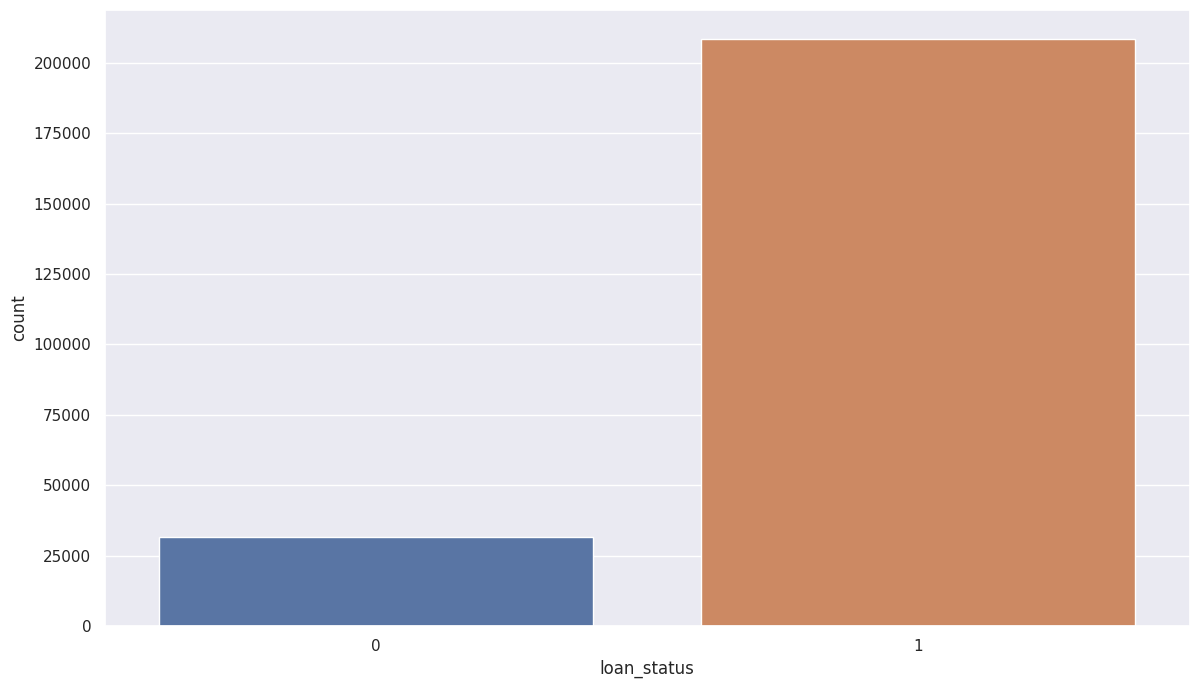

In [50]:
sns.countplot(x = train['loan_status'])

As seen above, the data is very imbalanced. Let us balance the data.

In [51]:
Y_train = train['loan_status']
X_train = train.drop(columns=['loan_status'])

In [52]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=seed)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(X_train, Y_train)
train = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [53]:
# delete unnecessary variables to save on RAM
del sm, oversampled_X, oversampled_Y

<Axes: xlabel='loan_status', ylabel='count'>

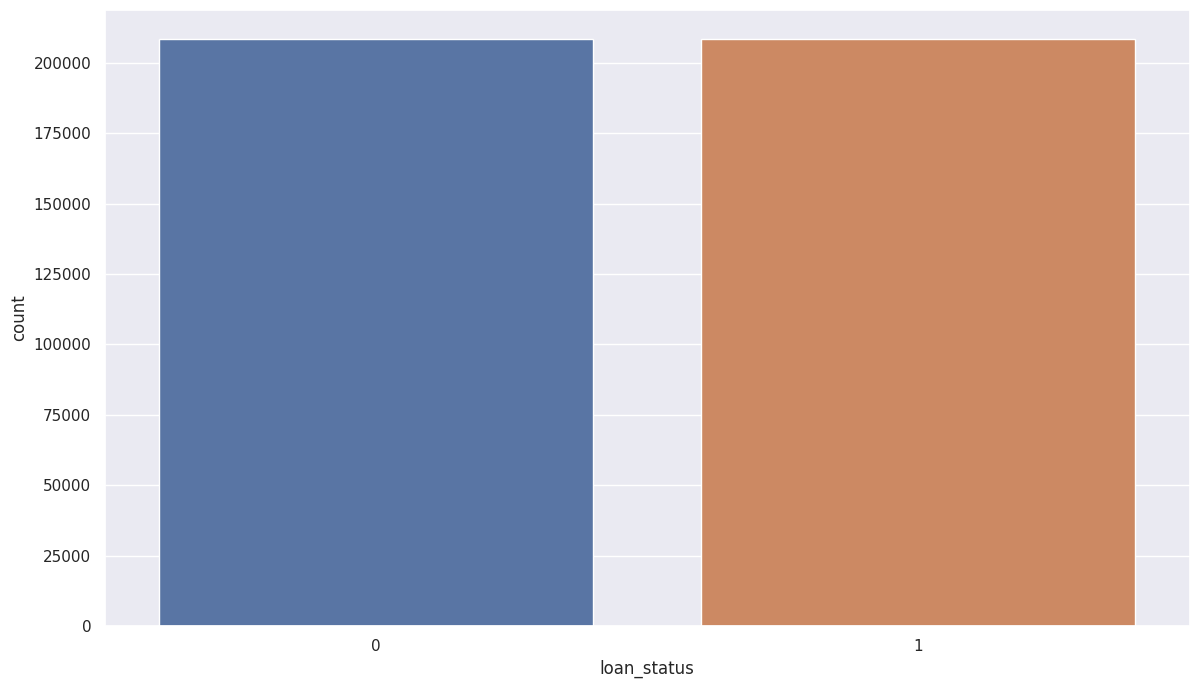

In [54]:
sns.countplot(x = train['loan_status'])

Now, our dataset is balanced and we can proceed to modeling.

## Train-Test Split

Let us separate the training dataset into features and the dependent variable.

In [55]:
Y_train = train['loan_status']
X_train = train.drop(columns=['loan_status'])

In [56]:
# preparing test datasets
Y_test = test['loan_status']
X_test = test.drop(columns=['loan_status'])

from sklearn.metrics import accuracy_score

## Random Forest

## Forward Step Feature Selection

We will perform a forward step feature selection process to determine which features should be included in our random forest to yield the most accurate results. Due to RAM limitations, we use default parameters on our random forest classification model when performing feature selection. Once we have our features selected, we will tune the hyperparameters using the determined subset of features.

In [57]:
# import the random forest classifier from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# perform forward stepwise selection to determine which features we should include in our model
# each entry is a fitted rf model
chosen_model = []
remaining_features = list(X_train.columns) # used to track what features haven't been tested
chosen_features = [] # used to track what features have been selected at the most recent iteration

# fit_rf is used to fit a random forest on the passed subset of features and calculate the model's accuracy based on that subset
def fit_rf(x_train, y_train, x_test, y_test):
  rf = RandomForestClassifier(random_state=42, n_estimators=20).fit(x_train,y_train)
  rf_pred = rf.predict(x_test)
  return {'model':rf,'accuracy':accuracy_score(rf_pred, y_test), 'features': list(x_train.columns)}

for i in range(1, len(X_train.columns)):
  # each element in the list is a dictionary with keys of 'model', 'accuracy', and 'features' as calculated in the fit_rf() function above
  ith_models = {'model':0,'accuracy':-1, 'features': []}

  # for each remaining feature, test that plus the most recent selected subset of features to see how accuracy changes
  for feat in remaining_features:
    ith_features = chosen_features + [feat]
    potential_model = fit_rf(X_train[ith_features], Y_train, X_test[ith_features], Y_test)
    # if this model is an improvement upon the accuracy of the previous "optimal" model on the i-th iteration, update the variable
    # while most forward step selection processes tend to compile a list of models within the i-th iteration and then identify the most accurate one, due to RAM limitations in Google Colab
    # the way our code identifies the most accurate model is modified to save on RAM
    if potential_model['accuracy'] > ith_models['accuracy']:
      ith_models = potential_model

  # append the most accurate model to the chosen_model list
  chosen_model.append(ith_models)
  # update chosen features to be used in future iterations of the loop
  chosen_features = ith_models['features']
  # remove the most recently chosen feature from the remaining features list
  remaining_features.remove(chosen_features[-1])
  del ith_models
  print(str(i)+"-th iteration completed")

# determine which of the optimal models is the most optimal
optimal_accuracy = -1
optimal_rf = None
for rf in chosen_model:
  if rf['accuracy'] > optimal_accuracy:
    optimal_rf = rf
    optimal_accuracy = rf['accuracy']

optimal_rf

1-th iteration completed
2-th iteration completed
3-th iteration completed
4-th iteration completed
5-th iteration completed
6-th iteration completed
7-th iteration completed
8-th iteration completed
9-th iteration completed
10-th iteration completed
11-th iteration completed
12-th iteration completed
13-th iteration completed
14-th iteration completed
15-th iteration completed
16-th iteration completed
17-th iteration completed
18-th iteration completed
19-th iteration completed
20-th iteration completed
21-th iteration completed
22-th iteration completed
23-th iteration completed
24-th iteration completed
25-th iteration completed
26-th iteration completed
27-th iteration completed
28-th iteration completed
29-th iteration completed
30-th iteration completed
31-th iteration completed
32-th iteration completed
33-th iteration completed
34-th iteration completed
35-th iteration completed
36-th iteration completed
37-th iteration completed
38-th iteration completed
39-th iteration compl

{'model': RandomForestClassifier(n_estimators=20, random_state=42),
 'accuracy': 0.9802166666666666,
 'features': ['total_rec_late_fee',
  'pymnt_plan_n',
  'purpose_other',
  'home_ownership_rent',
  'purpose_medical',
  'purpose_moving',
  'pymnt_plan_y',
  'purpose_vacation',
  'purpose_renewable_energy',
  'home_ownership_none',
  'collections_12_mths_ex_med',
  'home_ownership_any',
  'home_ownership_other',
  'purpose_wedding',
  'purpose_major_purchase',
  'purpose_house',
  'purpose_car',
  'pub_rec',
  'addr_state_5',
  'purpose_small_business',
  'tax_liens',
  'term',
  'addr_state_3',
  'addr_state_4',
  'emp_length',
  'purpose_home_improvement',
  'application_type_joint app',
  'application_type_individual',
  'pub_rec_bankruptcies',
  'home_ownership_own',
  'home_ownership_mortgage',
  'purpose_credit_card',
  'purpose_debt_consolidation',
  'addr_state_2',
  'addr_state_1',
  'verification_status_not verified',
  'verification_status_verified',
  'verification_status_

**Based on the above code, we know that the optimal model with a 98% accuracy uses the following subset of features:**

['total_rec_late_fee',
  'pymnt_plan_n',
  'purpose_other',
  'home_ownership_rent',
  'purpose_medical',
  'purpose_moving',
  'pymnt_plan_y',
  'purpose_vacation',
  'purpose_renewable_energy',
  'home_ownership_none',
  'collections_12_mths_ex_med',
  'home_ownership_any',
  'home_ownership_other',
  'purpose_wedding',
  'purpose_major_purchase',
  'purpose_house',
  'purpose_car',
  'pub_rec',
  'addr_state_5',
  'purpose_small_business',
  'tax_liens',
  'term',
  'addr_state_3',
  'addr_state_4',
  'emp_length',
  'purpose_home_improvement',
  'application_type_joint app',
  'application_type_individual',
  'pub_rec_bankruptcies',
  'home_ownership_own',
  'home_ownership_mortgage',
  'purpose_credit_card',
  'purpose_debt_consolidation',
  'addr_state_2',
  'addr_state_1',
  'verification_status_not verified',
  'verification_status_verified',
  'verification_status_source verified',
  'num_accts_ever_120_pd',
  'out_prncp',
  'total_rec_prncp',
  'loan_amnt',
  'total_pymnt',
  'last_pymnt_amnt',
  'installment',
  'total_bc_limit',
  'open_acc',
  'total_rec_int',
  'int_rate']

**The above text will be used to retrain a model and tune the hyperparameters**

## Hyperparameter Tuning

Now that we have determined the optimal subset of features, we will use these features to tune the model's hyperparameters, more specifically:


*   **n_estimators**: list(range(20, 101, 10))
*   **max_depth**: [None, 3, 4, 5, 6, 7, 8, 9, 10]

These hyperparameters were chosen from the sklearn documentation for the RandomForestClassifier class

In [60]:
# features taken from text cell above, which was sourced from the forward stepwise process
optimal_features = ['total_rec_late_fee', 'pymnt_plan_n', 'purpose_other', 'home_ownership_rent', 'purpose_medical', 'purpose_moving', 'pymnt_plan_y', 'purpose_vacation', 'purpose_renewable_energy', 'home_ownership_none', 'collections_12_mths_ex_med', 'home_ownership_any', 'home_ownership_other', 'purpose_wedding', 'purpose_major_purchase', 'purpose_house', 'purpose_car', 'pub_rec', 'addr_state_5', 'purpose_small_business', 'tax_liens', 'term', 'addr_state_3', 'addr_state_4', 'emp_length', 'purpose_home_improvement', 'application_type_joint app', 'application_type_individual', 'pub_rec_bankruptcies', 'home_ownership_own', 'home_ownership_mortgage', 'purpose_credit_card', 'purpose_debt_consolidation', 'addr_state_2', 'addr_state_1', 'verification_status_not verified', 'verification_status_verified', 'verification_status_source verified', 'num_accts_ever_120_pd', 'out_prncp', 'total_rec_prncp', 'loan_amnt', 'total_pymnt', 'last_pymnt_amnt', 'installment', 'total_bc_limit', 'open_acc', 'total_rec_int', 'int_rate']

Now let's tune our hyperparameters:


In [61]:
from sklearn.model_selection import GridSearchCV

# identify the parameters and what values for those parameters we are going to hypertune
params = {'max_depth':[None,3,4,5,6,7,8,9,10],
          'n_estimators':list(range(20,101,10))}

# instantiate the hypertuner via GridSearchCV
# using cv=5 to be more efficient with RAM
gridsearch = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=params, cv=5).fit(X_train[optimal_features],Y_train)

In [62]:
# identify the best model
best_model = gridsearch.best_estimator_.fit(X_train[optimal_features],Y_train)
rf_pred = best_model.predict(X_test[optimal_features])

After hypertuning our random forest model, we find that this combination of parameters is optimal:

In [63]:
gridsearch.best_estimator_

RandomForestClassifier(n_estimators=90, random_state=42)

In [64]:
print("Hypertuned rf train accuracy: "+str(round(gridsearch.best_score_, 4))) # round for ease of reading value
print("Hypertuned rf test accuracy: "+str(accuracy_score(rf_pred, Y_test)))

Hypertuned rf train accuracy: 0.9821
Hypertuned rf test accuracy: 0.9809166666666667


With the above, we have determined that the optimal random forest model will have the following hyperparameters:

n_estimators = 90; otherwise, default

As mentioned earlier, we will use these 'best' features and 'best' hyperparameters in the Random Forest Model within the main file.